<a href="https://colab.research.google.com/github/Dp20032/Neuromatch_BrainCancer/blob/Dhiren/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchsummary import summary

import os
from google.colab import files
from PIL import Image
import subprocess

In [2]:
# @title Data Loading
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
 89% 132M/149M [00:00<00:00, 234MB/s]
100% 149M/149M [00:00<00:00, 238MB/s]


In [3]:
# @title Download and processing Zenodo data - unneeded, data represented in original dataset
#!wget https://zenodo.org/record/7047164/files/adnoma.zip
#!wget https://zenodo.org/record/7047164/files/Gliomas.zip
#!wget https://zenodo.org/record/7047164/files/Meningioma.zip

def grab_format_zenodo(type='adnoma', size=(256,256)):
  url = f'https://zenodo.org/record/7047164/files/{type}.zip'
  print(f'Downloading {type}')
  subprocess.call(['wget', '-v', url])
  print(f'{type} acquired, unzipping...')
  subprocess.call(['unzip', '-q', f'{type}.zip'])
  files = os.listdir(f'./{type}')
  print(f'Unzipping {type} completed [{len(files)} samples extracted], beginning conversion...')
  size=(256,256)
  for i in files:
    im = Image.open(f'./{type}/{i}')
    i, _ = i.split('.')
    new = im.resize(size)
    if not os.path.isdir(f'./{type}_png'):
      os.mkdir(f'./{type}_png')
    new.save(f'./{type}_png/{i}.png', 'png')

# for i in ['adnoma', 'Gliomas', 'Meningioma']:
#   grab_format_zenodo(type=i)


In [4]:
classes = os.listdir('./Training/')

0 tensor([1, 2, 2, 0, 2, 3, 0, 0, 3, 0])


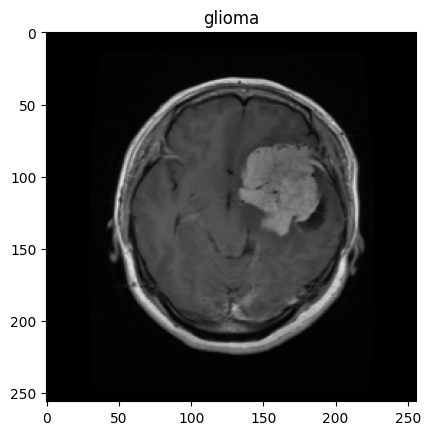

In [5]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])
import matplotlib.pyplot as plt
TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=10, shuffle=True)
for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [6]:
device= device = torch.device("cuda")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 67.8MB/s]


Epoch 1, Batch 50, Loss: 1.658
Epoch 1, Batch 100, Loss: 1.164
Epoch 1, Batch 150, Loss: 0.989
Epoch 1, Batch 200, Loss: 0.943
Epoch 1, Batch 250, Loss: 1.064
Epoch 1, Batch 300, Loss: 0.984
Epoch 1, Batch 350, Loss: 1.202
Epoch 1, Batch 400, Loss: 0.851
Epoch 1, Batch 450, Loss: 0.824
Epoch 1, Batch 500, Loss: 0.799
Epoch 1, Batch 550, Loss: 0.811
Epoch 1 Loss: 1.009
Epoch 2, Batch 50, Loss: 0.864
Epoch 2, Batch 100, Loss: 0.561
Epoch 2, Batch 150, Loss: 0.756
Epoch 2, Batch 200, Loss: 0.835
Epoch 2, Batch 250, Loss: 0.806
Epoch 2, Batch 300, Loss: 0.737
Epoch 2, Batch 350, Loss: 0.630
Epoch 2, Batch 400, Loss: 0.753
Epoch 2, Batch 450, Loss: 0.719
Epoch 2, Batch 500, Loss: 0.787
Epoch 2, Batch 550, Loss: 0.670
Epoch 2 Loss: 0.738
Epoch 3, Batch 50, Loss: 0.574
Epoch 3, Batch 100, Loss: 0.682
Epoch 3, Batch 150, Loss: 0.748
Epoch 3, Batch 200, Loss: 0.705
Epoch 3, Batch 250, Loss: 0.958
Epoch 3, Batch 300, Loss: 0.702
Epoch 3, Batch 350, Loss: 0.897
Epoch 3, Batch 400, Loss: 0.693
Epo

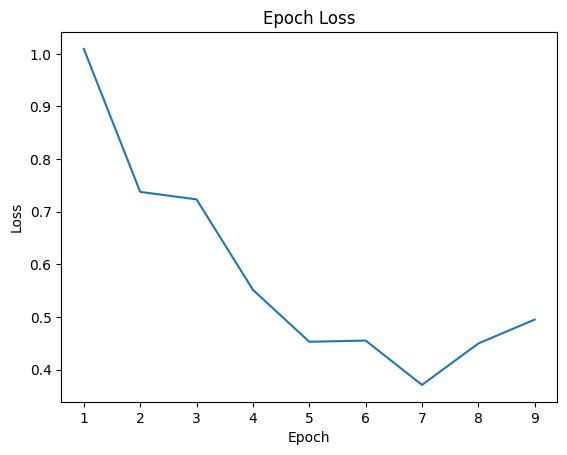

In [7]:
Classifier = models.vgg19(weights='DEFAULT')

for param in Classifier.features.parameters():
    param.requires_grad = False


#Replace the classifying linear network with one with custom number of output classes
num_features = Classifier.classifier[-1].in_features
Classifier.classifier[-1] = nn.Linear(num_features, 4)

Classifier = Classifier.to(device)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Classifier.parameters(), lr=0.001)



num_epochs = 200
epoch_loss = []
best_loss = np.inf
best_weights = None
patience = 2
no_improvement = 0


for epoch in range(num_epochs):
    running_loss = 0.0
    mini_batch_loss= 0.0
    for batch_number, (images, labels) in enumerate(TrainingLoader):

       images = images.to(device)
       labels = labels.to(device)

       optimizer.zero_grad()
       outputs = Classifier(images)
       loss = loss_function(outputs, labels)

       loss.backward()
       optimizer.step()

       running_loss += loss.item()
       mini_batch_loss += loss.item()

       if (batch_number + 1) % 50 == 0:
          print(f'Epoch {epoch + 1}, Batch {batch_number + 1}, Loss: {mini_batch_loss / 50:.3f}')
          mini_batch_loss = 0.0

    epoch_loss.append(running_loss / len(TrainingLoader))


    #Early Stopping

    if epoch_loss[-1] < best_loss:
        best_loss = epoch_loss[-1]
        best_weights = Classifier.state_dict()
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break


    print(f'Epoch {epoch + 1} Loss: {running_loss / len(TrainingLoader):.3f}')

print('Finished Training')

#Best Weights
Classifier.load_state_dict(best_weights)

print('Finished Training')

#Plots
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.show()